# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [21]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [22]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [23]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, rare_to_value=0.04)

In [24]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')

sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.



Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.98
Test evaluation --> roc_auc: 0.879
Time elapsed: 0.250s
-------------------------------------------------
Total time: 0.250s


Final results ==================== >>
Duration: 0.250s
-------------------------------------
LightGBM --> roc_auc: 0.879


## Deep Feature Synthesis

In [25]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [26]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added.


In [27]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Series([], dtype: int64)

In [28]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [29]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.09090909090909091 repeated in 100.0% of the rows.
 --> Feature MinTemp + RainToday_No was removed due to collinearity with another feature.
 --> Feature Location + MaxTemp was removed due to collinearity with another feature.
 --> Feature Rainfall - WindDir3pm was removed due to collinearity with another feature.
 --> Feature RainToday_No + WindGustSpeed was removed due to collinearity with another feature.
 --> Feature WindSpeed3pm was removed due to collinearity with another feature.
 --> Feature Humidity9am was removed due to collinearity with another feature.
 --> Feature Humidity9am - RainToday_other was removed due to collinearity with another feature.
 --> Feature Humidity3pm was removed due to collinearity with another feature.
 --> Feature Humidity3pm + RainToday_Yes was removed due to collinearity with another feature.
 --> Feature Humidity3pm + Sunshine 

In [30]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop,corr_feature,corr_value
0,MinTemp + RainToday_No,MinTemp,0.9978
1,Location + MaxTemp,MaxTemp,1.0
2,Rainfall - WindDir3pm,Rainfall,1.0
3,RainToday_No + WindGustSpeed,WindGustSpeed,0.9995
4,WindSpeed3pm,RainToday_other + WindSpeed3pm,1.0
5,Humidity9am,"Humidity9am + RainToday_other, Humidity9am - R...","1.0, 1.0"
6,Humidity9am - RainToday_other,"Humidity9am, Humidity9am + RainToday_other","1.0, 1.0"
7,Humidity3pm,"Humidity3pm + RainToday_Yes, Humidity3pm + Sun...","0.9998, 0.9916, 0.9998, 0.9998"
8,Humidity3pm + RainToday_Yes,"Humidity3pm, Humidity3pm + Sunshine, Humidity3...","0.9998, 0.9912, 1.0, 0.9993"
9,Humidity3pm + Sunshine,"Humidity3pm, Humidity3pm + RainToday_Yes, Humi...","0.9916, 0.9912, 0.9912, 0.9917"


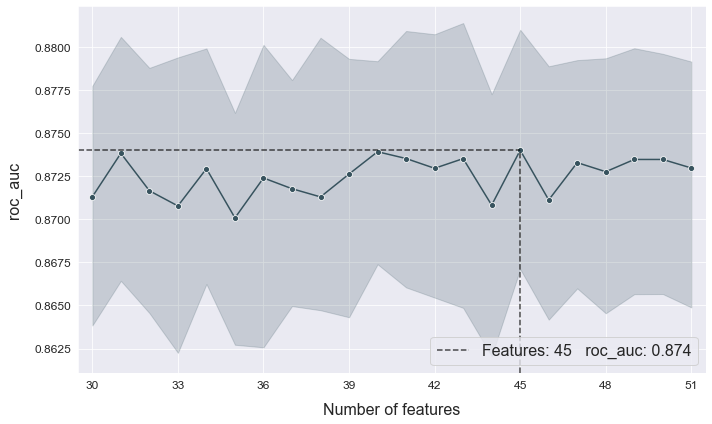

In [31]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [32]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9949
Test evaluation --> roc_auc: 0.8884
Time elapsed: 0.516s
-------------------------------------------------
Total time: 0.516s


Final results ==================== >>
Duration: 0.516s
-------------------------------------
LightGBM --> roc_auc: 0.8884


## Genetic Feature Generation

In [33]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [34]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.04         0.136973        4         0.513834              N/A     18.71s
   1     3.05         0.336392        5         0.520524              N/A     21.77s
   2     3.54         0.433237        5         0.530545              N/A     19.56s
   3     4.09         0.476537        9         0.543896              N/A     21.25s
   4     5.88         0.499316       17         0.559524              N/A     15.48s
   5     8.91          0.52323       19         0.561831              N/A     14.64s
   6     9.54         0.530888       17         0.561145              N/A     17.16s
   7    10.33         0.524547       17         0.563917              N/A     13.02s
   8    12.12         0.508475       17        

In [35]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,x23,"mul(mul(sub(add(Sunshine, add(WindSpeed3pm, Su...",0.549822
1,x24,"mul(mul(sub(add(WindSpeed3pm, add(Sunshine, Su...",0.549822
2,x25,"mul(mul(sub(add(add(Sunshine, WindSpeed3pm), S...",0.549822
3,x26,"mul(mul(sub(add(add(WindSpeed3pm, Sunshine), S...",0.549822
4,x27,"mul(mul(add(WindGustSpeed, Humidity3pm), add(H...",0.549822
5,x28,"mul(mul(sub(add(add(Sunshine, Sunshine), WindS...",0.549822
6,x29,"mul(mul(add(WindGustSpeed, Humidity3pm), add(H...",0.549822
7,x30,"mul(mul(sub(add(WindSpeed3pm, add(Sunshine, Su...",0.549659
8,x31,"mul(mul(sub(add(Sunshine, add(WindSpeed3pm, Su...",0.549659
9,x32,"mul(sub(add(Sunshine, add(WindSpeed3pm, Sunshi...",0.549659


In [36]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9818
Test evaluation --> roc_auc: 0.8856
Time elapsed: 0.422s
-------------------------------------------------
Total time: 0.422s


Final results ==================== >>
Duration: 0.422s
-------------------------------------
LightGBM --> roc_auc: 0.8856


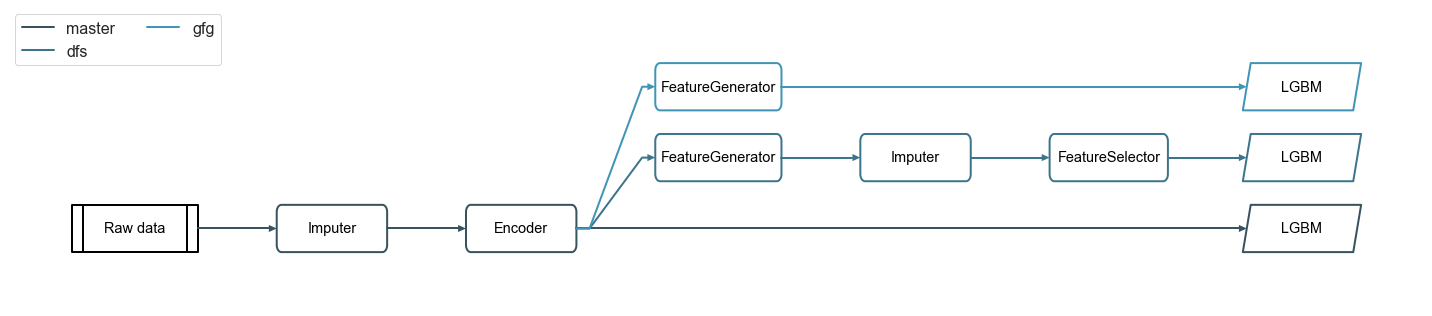

In [37]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze results

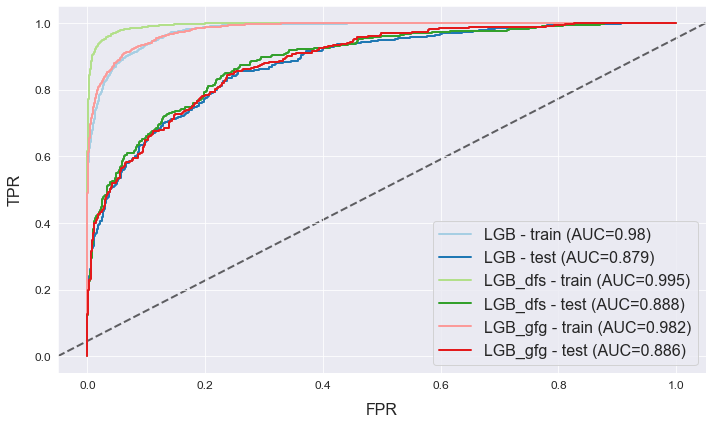

In [38]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

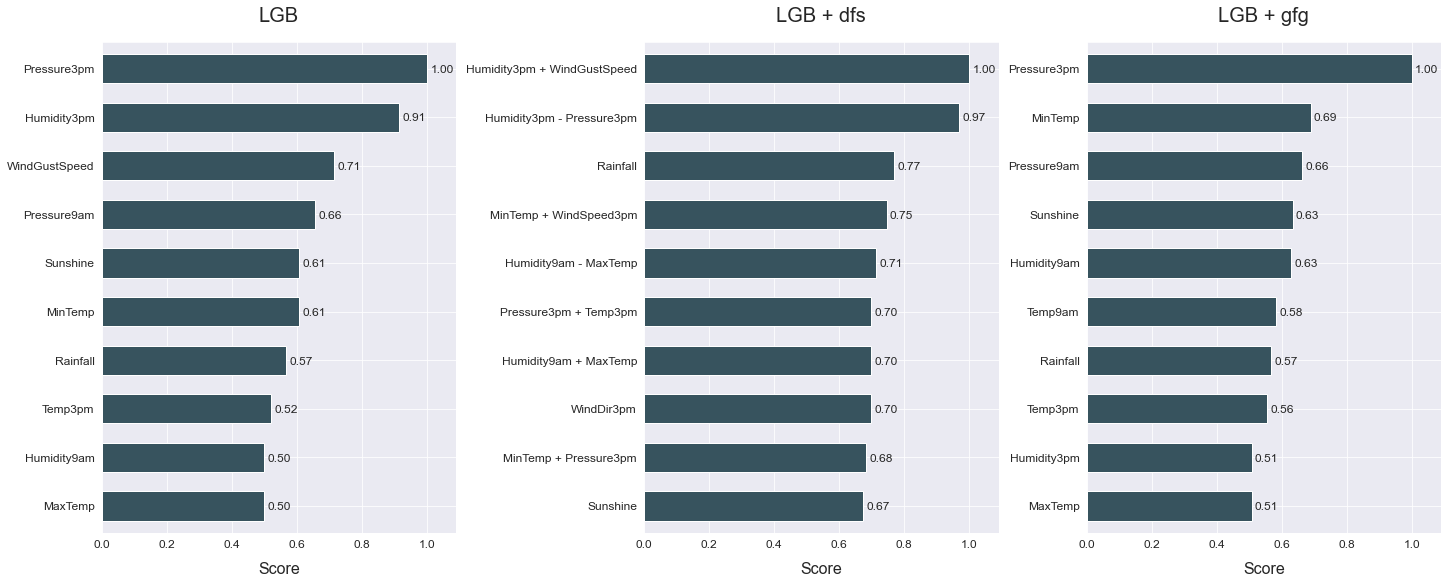

In [39]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + gfg")

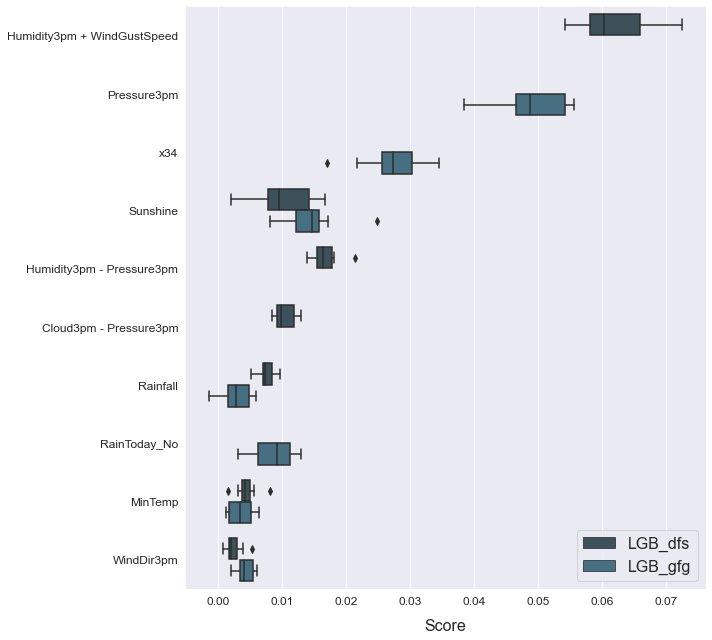

In [40]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=10)

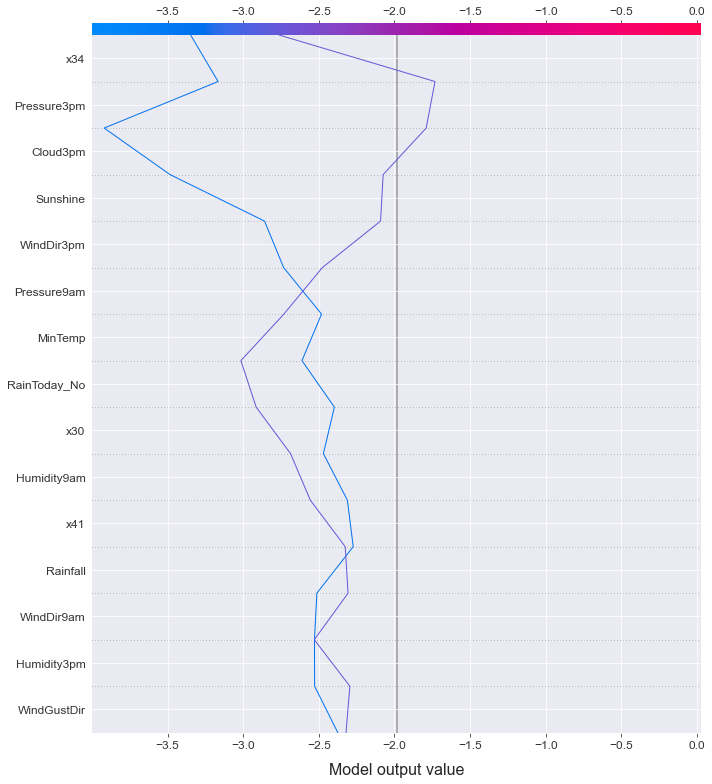

In [41]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)